# 1D floating, elastic beam (mixed formulation)

## Problem description

Consider a floating shelf of uniform thickness $H$, with fixed vertical deflection $\eta_0$ at the terminus. The shelf is loaded with a buoyancy force of $f = -\rho_wg\eta$. Let $M = M(x)$ represent the bending moment associated with the deflection $\eta = \eta(x)$, and define $\lambda := \frac{E}{12(1 - \mu^2)}$, where $E$ is Young's Modulus and $\mu$ is Poisson's Ratio. Then the governing equation and constitutive relation on the plate are:

$$
-M'' = -\rho_wg\eta
$$

$$
M = -H^3\lambda\eta''.
$$ 

Let $n$ and $m$ be arbitrary functions in $x$. From the product rule and the Fundamental Theorem of Calculus, it can be derived that the corresponding weak forms for these equations are:

$$
\int_xm'M' - [mM']_{x_0}^{x_1} = -\int_xm\rho_wg\eta
$$

$$
\int_xnM = \int_x(H^3\lambda n)'\eta' - [H^3\lambda n\eta']_{x_0}^{x_1}
$$

Consequently, define

$$ 
a := \int_xm'M' + \int_xnM - \int_x(H^3\lambda n)'\eta' + \int_xm\rho_wg\eta
$$

$$
L := 0
$$


The task is now to find $(M, \eta)$ such that $a = L$ for every $(n, m)$. 

## Imports

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

## Meshing and material parameters

I'll set the length of the shelf to $L = \frac{2n\pi}{\sqrt[4]{\frac{3(1 - \mu^2)}{EH^3}\rho_wg}}$ for some positive integer $n$ (this will give the analytic solution a nicer form).

In [2]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater
g = 9.81 #gravitational constant (N/kg)
H = 100 #thickness in meters
E = 1e9 #Young's Modulus (Pa)
μ = 1/3 #Poisson's Ratio
λ = E/(12*(1 - μ**2))
α = 1e10 #large number for penalty method
D = sqrt(sqrt((3*ρ_w*g*(1 - μ**2)/(E*H**3)))) #see above
n = 1 #see above

n_nodes = 200 #number of nodes
Lx = 2*n*pi/D #length of mesh in meters
print(f'L = {Lx:.2f} meters')
mesh = IntervalMesh(n_nodes, Lx)

Q1 = FunctionSpace(mesh, 'CG', 2) #this will be η's function space
Q2 = FunctionSpace(mesh, 'CG', 2) #and M's function space
Q = Q1*Q2 #mixed function space for (η, M)

η, M = TrialFunctions(Q) #deflection η, moment M_xx
n, m = TestFunctions(Q)

x = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting later

L = 2761.82 meters


## Set up and solve the problem

Boundary conditions will be $\eta(0) = M(0) = M'(L) = 0$, and $\eta(L) = \eta_0$. That is, there is no deflection or bending moment upstream; there is no shear force acting on the terminus; and the terminus deflection is fixed. Boundary conditions in $\eta$ and $M$ are essential and will be enforced using Firedrake's built-in ```DirichletBC```. Boundary conditions in $M'$ are enforced using the penalty method.

In [3]:
a = (grad(m)[0]*grad(M)[0])*dx + (n*M)*dx - (grad(H**3*λ*n)[0]*grad(η)[0])*dx + (ρ_w*g*η*m)*dx
L = 1e-10*m*dx #why doesn't this work with L = 0?

η_0 = -1
bc_1 = DirichletBC(Q.sub(0), Constant(0), (1)) #η = 0 upstream
bc_2 = DirichletBC(Q.sub(0), Constant(η_0), (2)) #η = η_0 at terminus 
bc_3 = DirichletBC(Q.sub(1), Constant(0), (1)) #M = 0 upstream
a += 1/2*α**2*(m*grad(M)[0])*ds(2) #also enforce M' = 0 (i.e., shear force is zero at the terminus)

q = Function(Q) # q = (η, M)
solve(a == L, q, bcs = [bc_1, bc_2, bc_3])

## Plot, and compare with the analytic solution

The analytic solution for the deflection is, given the setup and boundary conditions described above, is

$$\eta = \frac{\eta_0}{e^{DL} - e^{-DL}}\left(e^{Dx}\sin(Dx) + e^{-Dx}\sin(Dx) + e^{Dx}\cos(Dx) - e^{-Dx}\cos(Dx)\right),$$

with $D := \sqrt[4]{\frac{3(1 - \mu^2)}{EH^3}\rho_wg}$. 

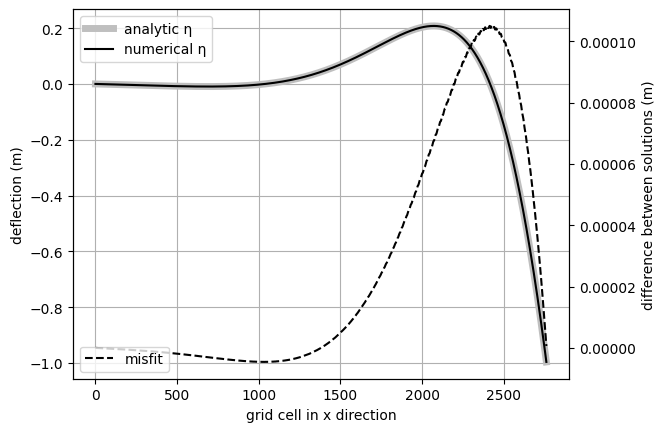

In [4]:
C_1 = η_0/(np.exp(D*Lx) - np.exp(-D*Lx)) 
analytic_profile = C_1*(np.exp(D*X)*np.sin(D*X) + np.exp(-D*X)*np.sin(D*X) + np.exp(D*X)*np.cos(D*X) - np.exp(-D*X)*np.cos(D*X))

modeled_η_profile = Function(Q2).project(q[0]).at(X, tolerance = 1e-10)
modeled_M_profile = Function(Q1).project(q[1]).at(X, tolerance = 1e-10)

plt.figure()
plt.plot(analytic_profile, color = '0.75', linewidth = 5, label = 'analytic η')
plt.plot(modeled_η_profile, color = 'k', linestyle = 'solid', label = 'numerical η')
plt.legend(loc = 'upper left')
plt.xlabel('grid cell in x direction')
plt.ylabel('deflection (m)')
plt.grid()
plt.twinx()
plt.plot(analytic_profile - modeled_η_profile, color = 'k', linestyle = 'dashed', label  = 'misfit')
plt.ylabel('difference between solutions (m)')
plt.legend(loc = 'lower left')